In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn import neural_network
from sklearn import pipeline
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.model_selection import cross_val_score

In [122]:
comp = pd.read_csv('../data/COMPUSTAT_vars.csv')
comp['datadate'] = pd.to_datetime(comp['datadate'])

# Concept
The data used here shows various outcomes from firms' financial statements combined with information about data breaches that happen to the firms. The idea is to create a machine learning model that will be able to predict certain outcomes in period t+1 using only data up to period t. For example predict firm revenue in 2015 using only data from before 2014. This is an example of time series prediction.

In [123]:
# Filter data to only firms that have one data breach to remove complication of handling multiple breaches
number_breaches = comp.groupby(by='GVKEY').apply(lambda x: len(x['breachdate'].unique()))
number_breaches = number_breaches.to_frame()
number_breaches = number_breaches.reset_index()
number_breaches.columns = ['GVKEY', 'nbreaches']
comp = pd.merge(comp, number_breaches, on='GVKEY', how='left')
comp = comp[comp['nbreaches'] == 1]

In [124]:
# Number of firms we are dealing with
len(comp['GVKEY'].unique())

269

For now consider only the pre data breach period. Split this by time period by some arbitrary amount, then use the first part as training, and the second part as validation.

In [125]:
def make_scaled_time(sl):
    start_date = sl['datadate'].min()
    end_date = sl['datadate'].max()
    length = end_date - start_date
    scaled_time = (sl['datadate'] - start_date)/length
    
    return pd.concat([scaled_time, sl['datadate'], sl['GVKEY']], axis=1)

In [126]:
comp_before = comp[comp['after'] == 0]
del comp_before['Unnamed: 0']
comp_before = comp_before.reset_index()
scaled_time = comp_before.groupby(by='GVKEY').apply(make_scaled_time)
scaled_time.columns = ['scaled_time', 'datadate', 'GVKEY']
comp_before = pd.merge(comp_before, scaled_time, how='left', on=['datadate', 'GVKEY'])
# 5 companies have only one observation and therefore scaled_time is nan
# Just going to remove these because they aren't interesting anyway
comp_before = comp_before[comp_before['scaled_time'].notnull()]
del comp_before['index']
comp_before

,datadate,gvkey,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,cusip,...,resid_pr_nott,resid_xoprq_tt,resid_xoprq_nott,resid_xsgaq_tt,resid_xsgaq_nott,resid_nopiq_tt,resid_nopiq_nott,resid_quarters_since_begin,nbreaches,scaled_time
0,2005-07-31,1013,2005,3,10,INDL,C,D,STD,000886309,...,-12.409384,285.096762,560.678519,27.501525,128.090269,18.141124,-19.439712,-0.931372,1,0.000000
1,2005-10-31,1013,2005,4,10,INDL,C,D,STD,000886309,...,-18.944871,47.754570,267.475921,3.271876,99.147397,38.816903,2.152977,-0.895455,1,0.167577
2,2006-01-31,1013,2006,1,10,INDL,C,D,STD,000886309,...,-60.174709,221.035135,479.485000,39.210338,130.800254,15.399436,-12.245600,-0.934691,1,0.335155
3,2006-04-30,1013,2006,2,10,INDL,C,D,STD,000886309,...,-56.440975,165.783806,345.719411,36.385091,114.384556,4.440181,-23.104819,-0.869868,1,0.497268
4,2006-07-31,1013,2006,3,10,INDL,C,D,STD,000886309,...,-80.009069,120.361713,322.044143,14.280891,105.620906,-0.562971,-24.024501,-0.850148,1,0.664845
5,2006-10-31,1013,2006,4,10,INDL,C,D,STD,000886309,...,-83.438231,-97.732425,-56.617120,-72.374658,-22.520508,0.147930,-25.450707,-0.730497,1,0.832423
6,2007-01-31,1013,2007,1,10,INDL,C,D,STD,000886309,...,-86.494984,95.146564,256.687994,0.183474,48.259213,-10.109201,-20.337999,-0.702522,1,1.000000
7,2005-06-30,1078,2005,2,12,INDL,C,D,STD,002824100,...,-1.213847,-568.181717,89.664987,-607.481232,-320.884246,-33.679477,8.276130,-4.297823,1,0.000000
8,2005-09-30,1078,2005,3,12,INDL,C,D,STD,002824100,...,-138.004138,-635.096888,91.467457,-669.037903,-400.555791,-19.810997,27.781151,-4.169176,1,0.021894
9,2005-12-31,1078,2005,4,12,INDL,C,D,STD,002824100,...,174.167374,-516.505451,150.764859,-626.690418,-363.019663,43.842672,86.253839,-4.133259,1,0.043789


Now we are ready to create the training and test sets.

In [173]:
training_cutoff = 0.75
outcomes = ['revtq', 'niq', 'xsgaq', 'xoprq'] # Revenue, Profit, Sales Expenses, Total Operating Expenses
excluded = ['fyr', 'datadate', 'indfmt', 'consol', 'popsrc', 'datafmt', 'cusip', 'curcdq', 'curncdq', 'currtrq', 'datacqtr', 'datafqtr']
inputs = [x for x in comp_before.columns[0:386].tolist() if x not in outcomes and x not in excluded]

# Remove non-numeric data, none of these are actually useful anyway
comp_before = comp_before.select_dtypes(exclude='object')
# Deal with NAs
comp_before = comp_before.interpolate(method='nearest')
comp_before = comp_before.fillna(0)

X_train = comp_before[comp_before['scaled_time'] < training_cutoff][inputs]
X_test = comp_before[comp_before['scaled_time'] >= training_cutoff][inputs]

y_train = comp_before[comp_before['scaled_time'] <  training_cutoff][outcomes[0]]
y_test = comp_before[comp_before['scaled_time'] >= training_cutoff][outcomes[0]]

In [188]:
# Boilerplate from PS8

# Fit models and return cv mse
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test, cv=5):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test)),
        mse_cv = -np.mean(cross_val_score(mod, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')),
        model = mod
    )

# pipeline with input scaling
def make_nn_model(params, activation='logistic', solver='lbfgs', alpha=0.0):
    nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
    neural_network.MLPRegressor(params,
                                activation=activation,
                                solver=solver,
                                alpha=alpha)
    )
    return nn_scaled_model
    
# Create nested list of all possible shapes for neural networks limited
# by max_depth and max_width (neurons at each level)
# Used to do grid search over the size of the neural net
def generate_nn_params(max_depth=2, max_width=10):
    out = [[i] for i in range(1, max_width + 1)]
    count = 0
    max_iter = sum([max_width**n for n in range(1, max_depth)])
    for j in out:
        if count >= max_iter:
            return out
        for i in range(1, max_width + 1):
            out += [j +[i]]
        count += 1

In [191]:
params = generate_nn_params(1, 5)
models = [make_nn_model(param) for param in params]

training_results = []
count = 0
for model in models:
    print('Training network with shape params {}'.format(params[count]))
    trained = fit_and_report_mses(model, X_train, X_test, y_train, y_test)
    training_results += [trained]
    count += 1
mse_nn = pd.DataFrame(training_results)
mse_nn['params'] = params

Training network with shape params [1]
Training network with shape params [2]
Training network with shape params [3]
Training network with shape params [4]
Training network with shape params [5]


In [192]:
optimal_model = mse_nn.iloc[mse_nn['mse_cv'].idxmin()]['model']

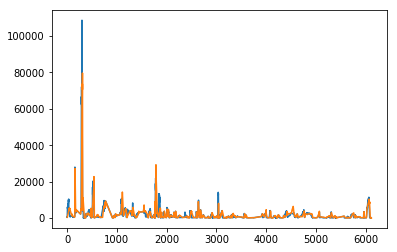

In [195]:
fig, ax = plt.subplots()
y_train.plot(ax=ax)
y_test.plot(ax=ax)